In [1]:
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.api import AutoReg
import pickle
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import json

import sys
sys.path.insert(0, "../Src/")
import loadData

%autosave 5

Autosaving every 5 seconds


Autosaving every 5 seconds


In [2]:
def determineDifferenceOrder(data):
    p = 100
    order = 0
    while p > 0.05:
        acf = plot_acf(data,title=f'acf diff order = {order}')
        pacf = plot_pacf(data, title=f'pacf diff order = {order}')
        adfTest = adfuller(data)
        p = adfTest[1]
        print(f'p: {adfTest[1]}')
        if p > 0.05:
            order += 1
            data = data.diff().dropna()
    return order

In [3]:
def trainArima(data):
    print('Training ARIMA')
    d = determineDifferenceOrder(data)
    possibleP = np.arange(d + 1)
    possibleQ = np.arange(d + 1)

    train, dev = trainDevSplit(data)

    bestArima = None
    bestMAE = np.inf
    bestP, bestQ = 0, 0

    for _ in range(20):
        p = np.random.choice(possibleP)
        q = np.random.choice(possibleQ)
        arima = ARIMA(train, order=(p, d, q))
        arimaFit = arima.fit()
        forecast = arimaFit.forecast(len(dev))
        mae = mean_absolute_error(dev, forecast)
        if mae < bestMAE:
            bestMAE = mae
            bestP, bestQ = p, q
    arima = ARIMA(data, order=(bestP, d, bestQ))
    arimaFit = arima.fit()
    print(arimaFit.summary())
    residuals = arimaFit.resid[1:]

    fig,ax = plt.subplots(1,2)
    residuals.plot(title = 'Residuals', ax = ax[0])
    residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])

    saveModel(arimaFit, 'arima')
    return arimaFit

In [4]:
def saveModel(model,name):
    filename = f'../Models/{name}.pkl'
    if name in ['autoRegression','sarima','ExponentialSmoothing', 'prophet']:
        with open(filename, 'wb') as pkl:
            pickle.dump(model, pkl)
    else:
        model.save(filename)

In [5]:
def trainSarima(train):
    print('Training Sarima')
    sarima = pm.auto_arima(train,stepwise=True,seasonal=True)
    print(sarima.summary())
    saveModel(sarima,'sarima')
    return sarima

In [6]:
def trainAutoRegression(data):
    print('Training AutoRegression')
    bestLag = 0
    bestCorr = 0
    for lag in range(1,11):
        corr = data.corr(data.shift(lag))
        if corr > bestCorr:
            bestLag = lag
            bestCorr = corr
    print(f'AR order = {bestLag}')
    ar_model = AutoReg(data, lags=bestLag)
    ar_model.fit()
    saveModel(ar_model,'autoRegression')
    return ar_model
    

In [7]:
def trainExponentialSmoothing(data):
    print('Training ExponentialSmoothing')
    arrayData = np.asarray(data)
    trainDevCutOff = int(len(arrayData) * 0.8)
    train = arrayData[:trainDevCutOff]
    dev = arrayData[trainDevCutOff:]

    possibleModels = [SimpleExpSmoothing, Holt, ExponentialSmoothing]
    possibleModelNames = ["SimpleExpSmoothing", "Holt", "ExponentialSmoothing"]
    bestMAE = np.inf

    bestModelIndex = 0
    bestSmoothingLevel = 0
    for _ in range(20):
        smoothingLevel = np.random.uniform(0.1, 0.9)
        modelIndex = np.random.choice(len(possibleModels))
        modelConstructor = possibleModels[modelIndex]
        model = modelConstructor(train)
        model_fit = model.fit(smoothing_level=smoothingLevel)
        forecast = model_fit.forecast(len(dev))
        mae = mean_absolute_error(dev, forecast)
        if mae < bestMAE:
            bestMAE = mae
            bestModelIndex = modelIndex
            bestSmoothingLevel = smoothingLevel
            
    print(f'model chosen {possibleModelNames[bestModelIndex]}')
    print(f'smoothing parameter {bestSmoothingLevel}')
    finalModelConstructor = possibleModels[bestModelIndex]
    final_model = finalModelConstructor(arrayData)
    final_model_fit = final_model.fit(smoothing_level=bestSmoothingLevel)
    
    saveModel(final_model_fit, 'ExponentialSmoothing')
    return model
    

In [8]:
def trainProphet(data):
    print('Training Prophet')
    train, dev = trainDevSplit(data)
    display(train)
    display(dev)

    bestMAE = np.inf
    bestParams = {}
    
    for _ in range(20):
        params = retrieveProphetParams()
        model = Prophet(**params)
        model.fit(train)
        
        future = model.make_future_dataframe(periods=dev.shape[0], freq='D')
        capValue = dev['y'].max() * 1.1
        future['cap'] = capValue
        future['floor'] = 0
        forecast = model.predict(future)
        forecast = forecast.iloc[-dev.shape[0]:]
        
        mae = mean_absolute_error(dev['y'], forecast['yhat'])
        
        if mae < bestMAE:
            bestMAE = mae
            bestParams = params
            

    model = Prophet(**bestParams)
    model.fit(data)
    
    saveModel(model, 'prophet')
    return model
        

In [9]:
def retrieveProphetParams():
    param_space = { 'growth' :['linear', 'logistic', 'flat'],
                   'n_changepoints': np.arange(0, 55, 5),
                   'changepoint_range': (0.5, 0.5),
                   'yearly_seasonality': [True, False],
                   'weekly_seasonality': [True, False],
                   'daily_seasonality': [True, False],
                   'seasonality_mode': ['additive', 'multiplicative'],
                   'seasonality_prior_scale': (5.0, 15.0),
                   'changepoint_prior_scale': (0.0, 0.1),
                   'interval_width': (0.2, 0.8),
                   'uncertainty_samples': [500, 1000, 1500, 2000]
                  }
    chosenParameters = dict()
    for key in param_space:
        if key in ['changepoint_range','seasonality_prior_scale','changepoint_prior_scale','interval_width']:
            bounds = param_space[key]
            chosenParameters[key] = np.random.uniform(bounds[0],bounds[1])
        else:
            chosenParameters[key] = np.random.choice(param_space[key])
    return chosenParameters
    

In [10]:
def trainLSTM(data):
    train, dev = trainDevSplit(data)
    XData, yData = loadData.processDataForLSTM(data)
    XTrain, yTrain = loadData.processDataForLSTM(train)
    XDev, yDev = loadData.processDataForLSTM(dev)
    
    bestTrainScore = np.inf
    bestDevScore = np.inf
    bestLSTMUnits1 = 0
    bestLSTMUnits2 = 0
    bestEpochs = 0
    for trial in range(20):    
        lstmUnits1 = np.random.choice(range(1,128))
        lstmUnits2 = np.random.choice(range(1,128))
        epochs = np.random.choice(range(1,100))

        model = compileLSTM(XTrain,yTrain,lstmUnits1,lstmUnits2,epochs)
        
        devScore = model.evaluate(XDev,yDev)[1]
        if devScore < bestDevScore:
            bestTrainScore = model.evaluate(XTrain,yTrain)[1]
            bestDevScore = devScore
            bestLSTMUnits1 = lstmUnits1
            bestLSTMUnits2 = lstmUnits2
            bestEpochs = epochs
    compileLSTM(XData,yData,bestLSTMUnits1,bestLSTMUnits2,bestEpochs)
    
    model_path = f'../Models/LSTM_.h5'
    model.save(model_path)
    bestModelParams = {
        'bestTrainScore': int(bestTrainScore),
        'bestDevScore': int(bestDevScore),
        'bestLSTMUnits1': int(bestLSTMUnits1),
        'bestLSTMUnits2': int(bestLSTMUnits2),
        'bestEpochs': int(bestEpochs)
    }
    with open('../Models/lstm_params.json', 'w') as f:
        json.dump(bestModelParams, f)
    
    return model
        

In [11]:
def trainDevSplit(data):
    totalRows = data.shape[0]
    trainDevCutoff = int(0.8 * totalRows)
    train = data.iloc[:trainDevCutoff]
    dev = data.iloc[trainDevCutoff:]
    return train,dev

In [12]:
def compileLSTM(X,y,lstmUnits1,lstmUnits2,epochs):
    model = Sequential()
    model.add(LSTM(units=lstmUnits1, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(units=lstmUnits2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_absolute_error'])
    model.fit(X, y, epochs=epochs, batch_size=32,verbose=0)
    return model

In [13]:
def main():
    train, test = loadData.loadData('MSFT')
    trainAutoRegression(train['y'])
    trainArima(train['y'])
    trainSarima(train['y'])
    trainExponentialSmoothing(train['y'])
    trainProphet(train)
    
    trainLSTM(train['y'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Training AutoRegression
AR order = 1
Training ARIMA
p: 0.8724888850412795
p: 1.2499416193356876e-18
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1047
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3133.879
Date:                Sun, 17 Nov 2024   AIC                           6269.758
Time:                        22:33:46   BIC                           6274.711
Sample:                             0   HQIC                          6271.636
                               - 1047                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        23.4353      0.768     30.500      0.000      21.929      24.941
Ljung-Box (L1) (Q):            

,ds,y,cap,floor
0,2020-01-02,160.619995,160.729996,158.330002
1,2020-01-03,158.619995,159.949997,158.059998
2,2020-01-06,159.029999,159.100006,156.509995
3,2020-01-07,157.580002,159.669998,157.320007
4,2020-01-08,160.089996,160.800003,157.949997
...,...,...,...,...
832,2023-04-24,281.769989,284.950012,278.720001
833,2023-04-25,275.420013,281.600006,275.369995
834,2023-04-26,295.369995,299.570007,292.730011
835,2023-04-27,304.829987,305.200012,295.250000


,ds,y,cap,floor
837,2023-05-01,305.559998,308.600006,305.149994
838,2023-05-02,305.410004,309.179993,303.910004
839,2023-05-03,304.399994,308.609985,304.089996
840,2023-05-04,305.410004,307.760010,303.399994
841,2023-05-05,310.649994,311.970001,304.269989
...,...,...,...,...
1042,2024-02-23,410.339996,415.859985,408.970001
1043,2024-02-26,407.540009,412.160004,407.359985
1044,2024-02-27,407.480011,408.320007,403.850006
1045,2024-02-28,407.720001,409.299988,405.320007


22:33:48 - cmdstanpy - INFO - Chain [1] start processing
22:33:48 - cmdstanpy - INFO - Chain [1] done processing
22:33:48 - cmdstanpy - INFO - Chain [1] start processing
22:33:48 - cmdstanpy - INFO - Chain [1] done processing
22:33:48 - cmdstanpy - INFO - Chain [1] start processing
22:33:48 - cmdstanpy - INFO - Chain [1] done processing
22:33:49 - cmdstanpy - INFO - Chain [1] start processing
22:33:49 - cmdstanpy - INFO - Chain [1] done processing
22:33:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:33:49 - cmdstanpy - INFO - Chain [1] start processing
22:33:49 - cmdstanpy - INFO - Chain [1] done processing
22:33:50 - cmdstanpy - INFO - Chain [1] start processing
22:33:50 - cmdstanpy - INFO - Chain [1] done processing
22:33:50 - cmdstanpy - INFO - Chain [1] start processing
22:33:50 - cmdstanpy - INFO - Chain [1] done processing
22:33:50 - cmdstanpy - INFO - Chain [1] start process

1/6 [====>.........................] - ETA: 1s - loss: 229.8423 - mean_absolute_error: 229.8423

2024-11-17 22:34:14.307187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:34:14.307638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:34:14.308179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 6ms/step - loss: 143.9787 - mean_absolute_error: 143.9787


2024-11-17 22:34:14.780929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:34:14.781450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:34:14.781903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 2ms/step - loss: 339.2255 - mean_absolute_error: 339.2255


2024-11-17 22:34:17.010718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:34:17.011235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:34:17.011815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/6 [====>.........................] - ETA: 1s - loss: 165.4953 - mean_absolute_error: 165.4953

2024-11-17 22:34:42.652081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:34:42.652525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:34:42.653038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 3ms/step - loss: 80.8107 - mean_absolute_error: 80.8107


2024-11-17 22:34:43.034872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:34:43.035245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:34:43.035707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/6 [====>.........................] - ETA: 1s - loss: 321.5895 - mean_absolute_error: 321.5895

2024-11-17 22:34:51.491175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:34:51.491718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:34:51.492349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 2ms/step - loss: 340.0585 - mean_absolute_error: 340.0585


2024-11-17 22:34:51.752445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:34:51.753326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:34:51.753807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 3ms/step - loss: 278.0146 - mean_absolute_error: 278.0146


2024-11-17 22:35:02.611746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:35:02.612195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:35:02.612872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/6 [====>.........................] - ETA: 1s - loss: 128.3894 - mean_absolute_error: 128.3894

2024-11-17 22:35:44.840062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:35:44.840526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:35:44.841140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 0s 5ms/step - loss: 51.0287 - mean_absolute_error: 51.0287


2024-11-17 22:35:45.274482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:35:45.274862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:35:45.275389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 3ms/step - loss: 319.5639 - mean_absolute_error: 319.5639


2024-11-17 22:35:52.320263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:35:52.320644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:35:52.321048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/6 [====>.........................] - ETA: 1s - loss: 250.6530 - mean_absolute_error: 250.6530

2024-11-17 22:36:14.295745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:36:14.296198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:36:14.296779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 3ms/step - loss: 269.1220 - mean_absolute_error: 269.1220


2024-11-17 22:36:14.556736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:36:14.557585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:36:14.558154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 3ms/step - loss: 302.8084 - mean_absolute_error: 302.8084


2024-11-17 22:36:28.343389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:36:28.343848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:36:28.344508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 2ms/step - loss: 334.5124 - mean_absolute_error: 334.5124


2024-11-17 22:36:40.808358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:36:40.808805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:36:40.809396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 3ms/step - loss: 253.2271 - mean_absolute_error: 253.2271


2024-11-17 22:36:55.242770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:36:55.243219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:36:55.243634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 3ms/step - loss: 230.2491 - mean_absolute_error: 230.2491


2024-11-17 22:37:07.199205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:37:07.199653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:37:07.200074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/6 [====>.........................] - ETA: 1s - loss: 217.5149 - mean_absolute_error: 217.5149

2024-11-17 22:37:18.113971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:37:18.114415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:37:18.114847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 4ms/step - loss: 235.9839 - mean_absolute_error: 235.9839


2024-11-17 22:37:18.376831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:37:18.377206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:37:18.377711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/6 [====>.........................] - ETA: 1s - loss: 187.5534 - mean_absolute_error: 187.5534

2024-11-17 22:37:35.667283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:37:35.667728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:37:35.668144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 3ms/step - loss: 206.0224 - mean_absolute_error: 206.0224


2024-11-17 22:37:35.935889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:37:35.936272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:37:35.936687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 3ms/step - loss: 275.3546 - mean_absolute_error: 275.3546


2024-11-17 22:37:44.639123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:37:44.639682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:37:44.640284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/6 [====>.........................] - ETA: 1s - loss: 234.4476 - mean_absolute_error: 234.4476

2024-11-17 22:37:55.214953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:37:55.215465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:37:55.216127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 3ms/step - loss: 252.9166 - mean_absolute_error: 252.9166


2024-11-17 22:37:55.478024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:37:55.478672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:37:55.479306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/6 [====>.........................] - ETA: 1s - loss: 266.1263 - mean_absolute_error: 266.1263

2024-11-17 22:38:06.130156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:38:06.130606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:38:06.131303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 5ms/step - loss: 284.5953 - mean_absolute_error: 284.5953


2024-11-17 22:38:06.412368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:38:06.412755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:38:06.413135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 2ms/step - loss: 349.3417 - mean_absolute_error: 349.3417


2024-11-17 22:38:11.276525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:38:11.277115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:38:11.277779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 3ms/step - loss: 277.3227 - mean_absolute_error: 277.3227


2024-11-17 22:38:27.913547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:38:27.914218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:38:27.914794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/6 [====>.........................] - ETA: 1s - loss: 298.2102 - mean_absolute_error: 298.2102

2024-11-17 22:38:43.759937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:38:43.760595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:38:43.761326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 4ms/step - loss: 316.6792 - mean_absolute_error: 316.6792


2024-11-17 22:38:44.028688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-17 22:38:44.029560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-17 22:38:44.030127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

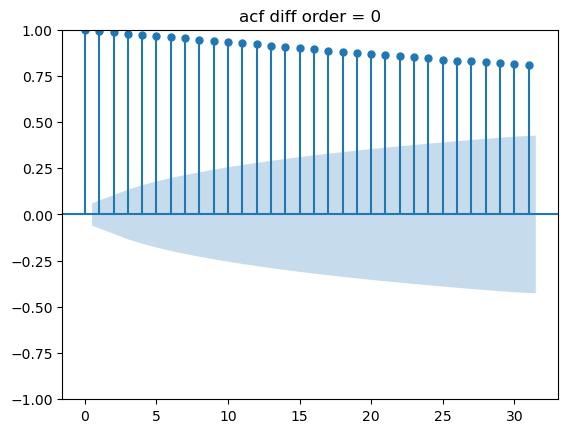

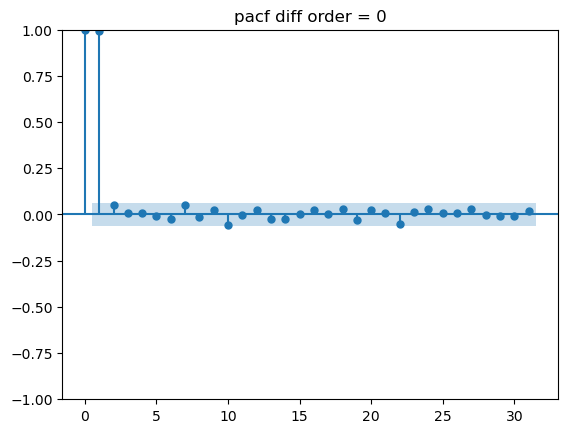

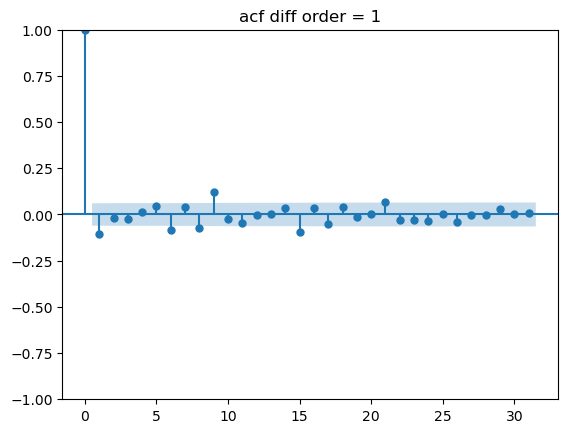

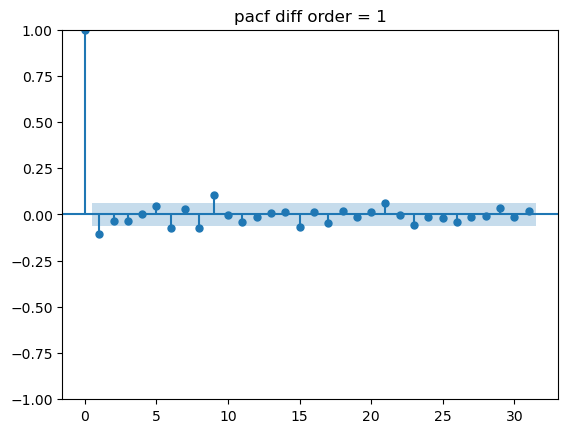

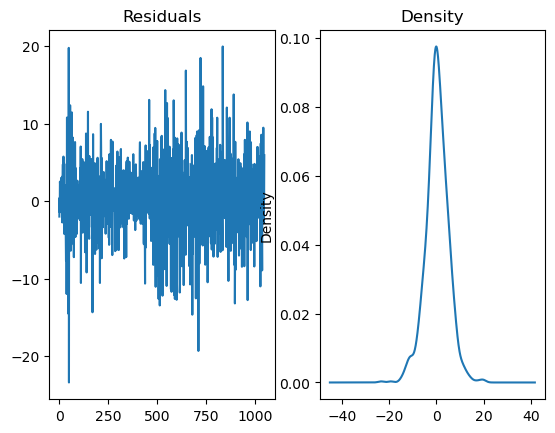

In [14]:
if __name__ == '__main__':
    main()